## ** Advanced Lane Finding Project **

### Camera Calibration
#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.



In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#Load all images and turn them into grey
#return: grey images list
def load_gray_images():
    images = []
    img_filenames = glob.glob('./camera_cal/calibration*.jpg')
    for filename in img_filenames:
        gray_image = cv2.cvtColor(mpimg.imread(filename), cv2.COLOR_RGB2GRAY)
        images.append(gray_image)
    return images


#Get camera matrix and the distortion coefficients of the given gray images
#return:
# camera_matrix - Output 3x3 floating-point matrix 
# dist_coeffs - Output vector of distortion coefficients (k_1, k_2, p_1, p_2[, k_3[, k_4, k_5, k_6]])   
def get_camera_matrix_and_dist_coeffs(gray_images):
    chessboard_dim = (9,6) # pattern size
    imgp = [] # 2d points in image plane.

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0) (code from udacity example.py)
    # matrix of the projections of calibration pattern points 
    objp = [] # 3d points in real world space (original chessboard image)
    object_points = np.zeros((6*9,3), np.float32)
    object_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    for image in gray_images:
        corners_found, corners = cv2.findChessboardCorners(image, chessboard_dim, None)
        if corners_found == True:
            objp.append(object_points)
            imgp.append(corners)

    _,camera_matrix,dist_coeffs,_,_ = cv2.calibrateCamera(objp, imgp, gray_images[0].shape[0:2], None, None)  
    return [camera_matrix,dist_coeffs]


#Get distortion correction to raw image
#return: undistortion image 
def undistort_image(src_img, camera_matrix, dist_coeffs):
    return cv2.undistort(src_img, camera_matrix, dist_coeffs, None, camera_matrix) 


def show_picture(image, title, grid, position):
    ax = plt.subplot2grid(grid, position)
    ax.imshow(image) 
    ax.set_title(title)
    return ax

def show_gray_picture(image, title, grid, position):
    ax = plt.subplot2grid(grid, position)
    ax.imshow(image, cmap='gray') 
    ax.set_title(title)
    return ax

There are 20 images with distortion available. These images are converted to gray images. Each image is determined by the corners (9x6) and the cv2 calibrate camera function is used to determine the camera matrix and the distortion coefficients. The camera matrix and the distortion coefficients can be used to remove equalization per image. After the undistortion, the images must be converted back to the RGB images.

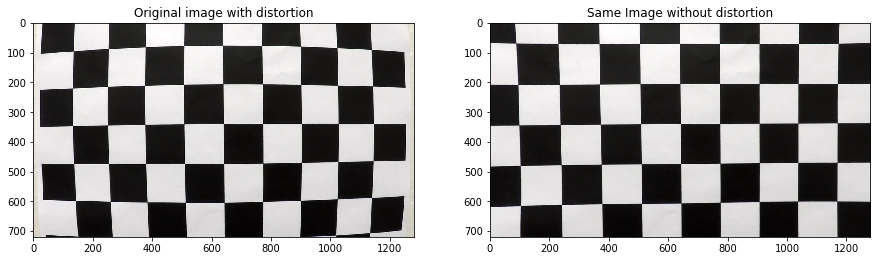

In [2]:
gray_images = load_gray_images()
camera_matrix,dist_coeffs = get_camera_matrix_and_dist_coeffs(gray_images)

test_image_src = mpimg.imread('./camera_cal/calibration1.jpg')
test_image_dest = undistort_image(test_image_src, camera_matrix, dist_coeffs)

plt.rc('figure', figsize=(15,15))

show_picture(test_image_src, "Original image with distortion", (1,2), (0,0))
show_picture(test_image_dest, "Same Image without distortion", (1,2), (0,1))

### Pipeline (single images)
#### 1. Provide an example of a distortion-corrected image.
The green bushes at the edges of the image are moved after the distortion of the image.

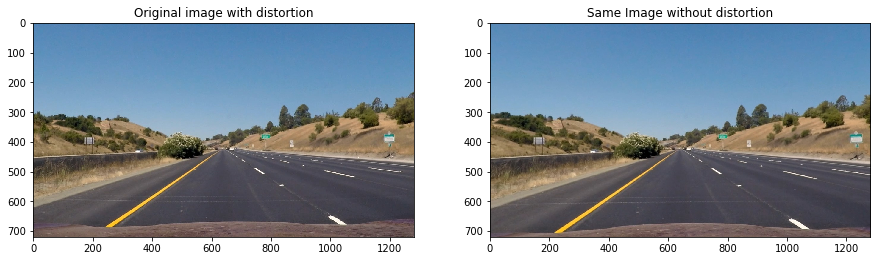

In [3]:
test2_src = mpimg.imread('./test_images/straight_lines1.jpg') # 2
test2_dst = undistort_image(test2_src, camera_matrix, dist_coeffs)

mpimg.imsave('./output_images/undistort_straight_lines1.jpg', test2_dst)

plt.rc('figure', figsize=(15,15))

show_picture(test2_src, "Original image with distortion", (1,2), (0,0))
show_picture(test2_dst, "Same Image without distortion", (1,2), (0,1))

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.


In [4]:
def abs_sobel_thresh(gray_img, orient:('x','y')='x', sobel_thresh=(0, 255)): #-
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)    
    abs_sobel = np.absolute(sobel)    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1

    return binary_output


def dir_threshold(gray_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction
    abs_sobely = np.absolute(sobely)
    abs_sobelx = np.absolute(sobelx)
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

The road has yellow and white boundary lines, the whites are often interrupted. The pavement of the streets alternates between dark and bright. In many bright areas there are white portions. The trees cast shadows on the road and change the color of the boundary lines

I have examined the color spaces RGB, HLS, Lab and YUV. To do this, I used color thresholds as well as various Soeble filters to better represent the boundary line patterns in binary images and to remove the disturbing road surfaces.

First I successfully tested grey images with Absolute-Soeble-filters and Direction-Soeble-filters. Then I combined both filters. By both filters I can remove light/dark areas on the lines a bit.

The Absolute-Soeble-filter is OK in the x-direction. The Absolute-Soeble-filter in the y-direction recognized the lines but with more interference. That's why I didn't use it anymore.

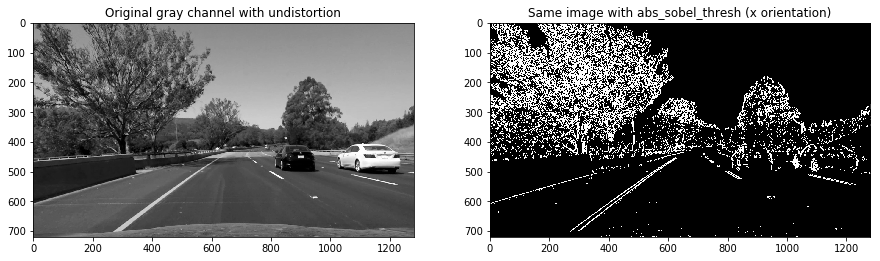

In [5]:
from ipywidgets import widgets, fixed, interact, Dropdown, IntSlider, FloatSlider
from IPython.display import display

test2_src = mpimg.imread('./test_images/test6.jpg') 
test2_dst = undistort_image(test2_src, camera_matrix, dist_coeffs)


@interact(min_thr=IntSlider(min=0,max=255,step=1,value=15), \
          max_thr=IntSlider(min=0,max=255,step=1,value=150))
def test_abs_sobel_thresh_gray(min_thr, max_thr): #20
    gray_img = cv2.cvtColor(test2_dst, cv2.COLOR_RGB2GRAY)

    dest_img2 = abs_sobel_thresh(gray_img, 'x', sobel_thresh=(min_thr, max_thr))
    
    plt.rc('figure', figsize=(15,15))
    show_gray_picture(gray_img, "Original gray channel with undistortion", (1,2), (0,0))
    show_gray_picture(dest_img2, "Same image with abs_sobel_thresh (x orientation)", (1,2), (0,1))

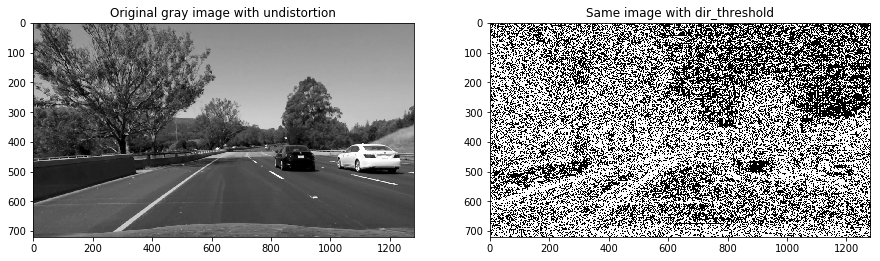

In [6]:
@interact(kernel=IntSlider(min=1,max=33,step=2,value=3), \
          min_thr=FloatSlider(min=-3.0,max=3.0,step=0.1,value=0.5), \
          max_thr=FloatSlider(min=-3.0,max=3.0,step=0.1,value=1.5))
def test_dir_threshold_gray(kernel, min_thr, max_thr):
    gray_img = cv2.cvtColor(test2_dst, cv2.COLOR_RGB2GRAY)

    dest_img = dir_threshold(gray_img, sobel_kernel=kernel, thresh=(min_thr, max_thr))
    
    plt.rc('figure', figsize=(15,15))
    show_gray_picture(gray_img, "Original gray image with undistortion", (1,2), (0,0))
    show_gray_picture(dest_img, "Same image with dir_threshold", (1,2), (0,1))

The combination of the absolute-Soeble-Filter and direction-Soeble-filter with grayscale image. The same combination with other color space channels had same or worse results.

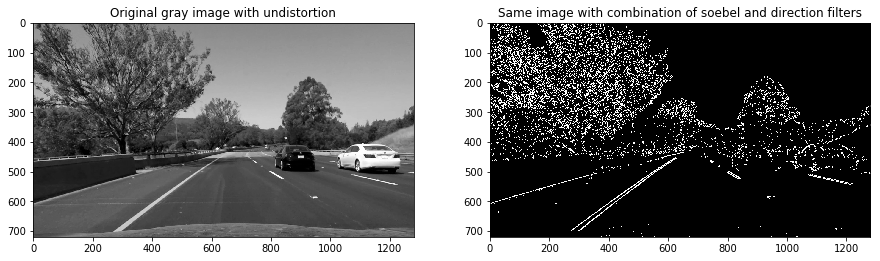

In [7]:
def combine_soebel_and_direction(gray_img):
    abs_sobel_img = abs_sobel_thresh(gray_img, 'x', sobel_thresh=(15, 150))
    direction_img = dir_threshold(gray_img, sobel_kernel=1, thresh=(0.5, 1.5))
    # combine the absolute soebel gradient and direction thresholds
    combined_condition = ((abs_sobel_img == 1) & (direction_img == 1))
    return combined_condition
    
gray_img = cv2.cvtColor(test2_dst, cv2.COLOR_RGB2GRAY)

dest_img = combine_soebel_and_direction(gray_img)
combined_binary  = np.zeros_like(gray_img)
combined_binary[gray_img] = 1     
plt.rc('figure', figsize=(15,15))
show_gray_picture(gray_img, "Original gray image with undistortion", (1,2), (0,0))
show_gray_picture(dest_img, "Same image with combination of soebel and direction filters", (1,2), (0,1))


Color thresholds: 

Red from RGB color Space can be used to determine yellow and white lines . Yellow or the combination of red and yellow does not improve the determination. Blue did not bring a good result.

If the pavement becomes very bright, red or yellow also represents it.

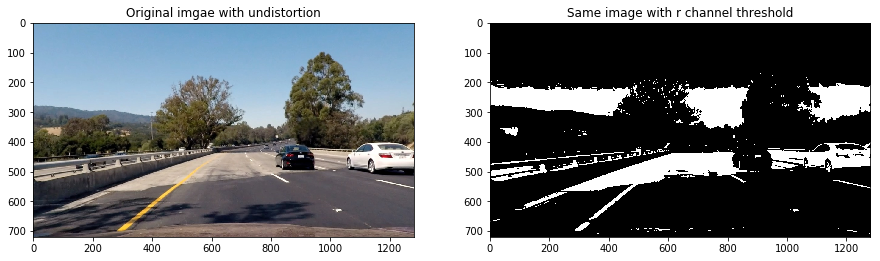

In [8]:
from ipywidgets import widgets, fixed, interact, Dropdown, IntSlider, FloatSlider
from IPython.display import display

test2_src = mpimg.imread('./test_images/test4.jpg') 
rgb_img = undistort_image(test2_src, camera_matrix, dist_coeffs)

def color_R_thresh(rgb_img, color_thr):
    r_img = rgb_img[:,:,0]
    r_thr = (r_img > color_thr) 
    return r_thr

@interact(color_thr=IntSlider(min=0,max=255,step=1,value=160))
def test_color_thresh_R(color_thr):
    r_thr = color_R_thresh(rgb_img, color_thr)
    color_binary  = np.zeros_like(gray_img)
    color_binary[r_thr] = 1    
    plt.rc('figure', figsize=(15,15))
    show_gray_picture(rgb_img, "Original imgae with undistortion", (1,2), (0,0))
    show_gray_picture(color_binary, "Same image with r channel threshold", (1,2), (0,1))

The channels of the LAB and YUV color space have not made any improvements to the HLS colorspace. That's why I chose the HLS color space.

The H channel in the HLS color space converts the lines to black and the pavement of the road is displayed very brightly. Thus, broken lines can only be localized very poorly. In the L and S channel you can find lines. Through the L channel the dark spots can be eliminated. But the channel is similar to the red channel in the RGB color space and thus does not bring any improvements.


That's why I used the S channel in the HLS color space. With the S channel, white lines can be found of light substrates.

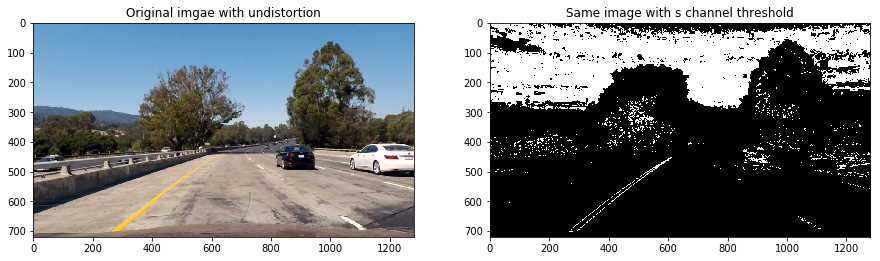

In [9]:
from ipywidgets import widgets, fixed, interact, Dropdown, IntSlider, FloatSlider
from IPython.display import display

test2_src = mpimg.imread('./test_images/test1.jpg') 
rgb_img = undistort_image(test2_src, camera_matrix, dist_coeffs)

def color_S_thresh(rgb_img, min_thr, max_thr):
    hls_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    s_img = hls_img[:,:,2]
    s_thr = (s_img >= min_thr) & (s_img < max_thr)
    return s_thr

@interact(min_thr=IntSlider(min=0,max=255,step=1,value=123), \
          max_thr=IntSlider(min=0,max=255,step=1,value=200))
def test_color_thresh_S(min_thr, max_thr):
    s_thr = color_S_thresh(rgb_img, min_thr, max_thr)
    color_binary  = np.zeros_like(gray_img)
    color_binary[s_thr] = 1    
    plt.rc('figure', figsize=(15,15))
    show_gray_picture(rgb_img, "Original imgae with undistortion", (1,2), (0,0))
    show_gray_picture(color_binary, "Same image with s channel threshold", (1,2), (0,1))

You can use the magnitude of the gradient filter to fix problems with bright surfaces. Unfortunately, the filter widens the lines very much and disturbs the histogram for line search algorithm; That's why I don't use it here; But as an example listed here as well.

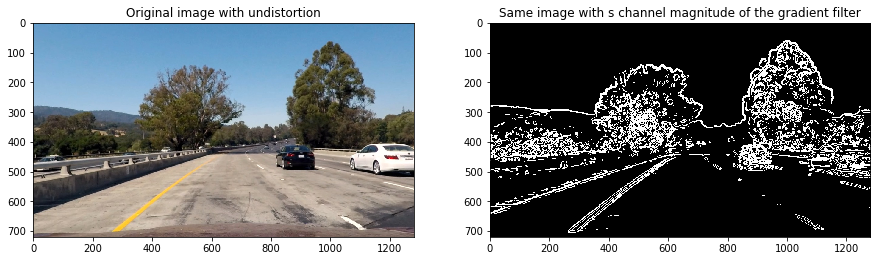

In [10]:
test2_src = mpimg.imread('./test_images/test1.jpg') 
rgb_img = undistort_image(test2_src, camera_matrix, dist_coeffs)

def mag_thresh_S(rgb_img, kernel, min_thr, max_thr):
    hls_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    s_img = hls_img[:,:,2]
    mag_thr = mag_thresh(s_img, sobel_kernel=kernel, mag_thresh=(min_thr, max_thr))
    return mag_thr

@interact(kernel=IntSlider(min=1,max=21,step=2,value=11), \
          min_thr=IntSlider(min=0,max=255,step=1,value=25), \
          max_thr=IntSlider(min=0,max=255,step=1,value=100))
def test_mag_thresh_S(kernel, min_thr, max_thr):
    dest_img = mag_thresh_S(rgb_img, kernel, min_thr, max_thr)
    
    plt.rc('figure', figsize=(15,15))
    show_gray_picture(rgb_img, "Original image with undistortion", (1,2), (0,0))
    show_gray_picture(dest_img, "Same image with s channel magnitude of the gradient filter", (1,2), (0,1))


#### The combination of thresholds

Here is the final combination of the filters. This reduces the problems with bright areas and shadows on the lines. 

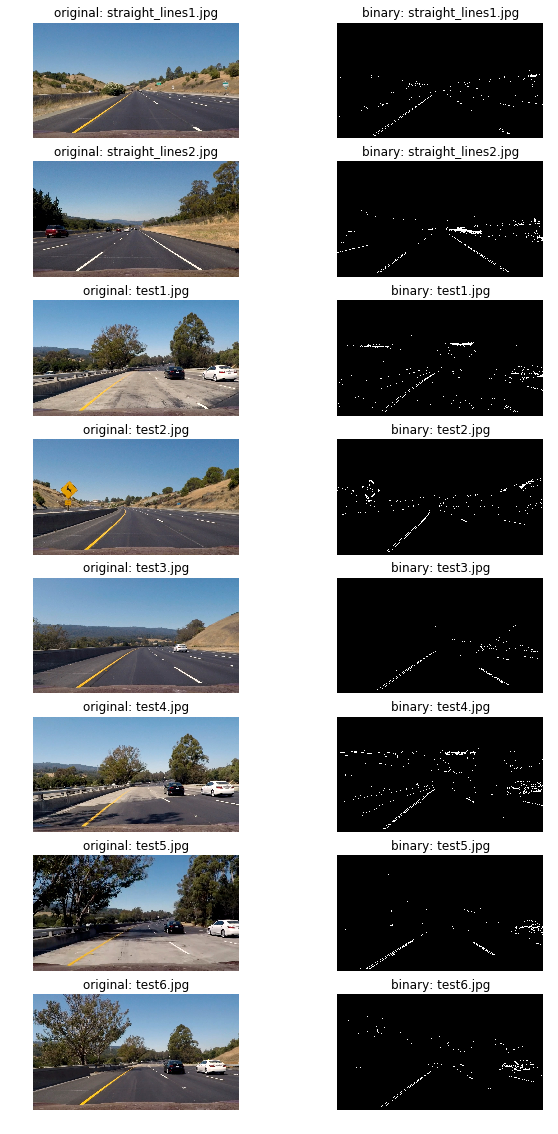

In [11]:
import os

def combined_binary(rgb_img):
    
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    soebel_and_direction_thr = combine_soebel_and_direction(gray_img)
    color_S_thr = color_S_thresh(rgb_img, 123, 200)
    color_R_thr = color_R_thresh(rgb_img, 160)

    color_binary  = np.zeros_like(gray_img)
    color_binary[ (color_R_thr) & (soebel_and_direction_thr | color_S_thr) ] = 1    

    return color_binary

image_paths = glob.glob('./test_images/*.jpg')
                                          
plt.rc('figure', figsize=(10,20))


for i in range(0, 8):
    ax = plt.subplot2grid((8,2), (i,0))
    test2_src = mpimg.imread(image_paths[i])
    ax.imshow(test2_src) #, cmap=plt.get_cmap('gray'))
    ax.set_title("original: " + os.path.basename(image_paths[i]))
    ax.axis('off')

    ax = plt.subplot2grid((8,2), (i,1))
    test2_dst = undistort_image(test2_src, camera_matrix, dist_coeffs)
    combined_binary_img = combined_binary(test2_dst)
    ax.imshow(combined_binary_img, cmap='gray')
    ax.set_title("binary: " + os.path.basename(image_paths[i]))
    ax.axis('off')

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.


In [12]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

def draw_into_image(img):
    pts = np.array([(595,445), \
                    (685,445),\
                    (1115,720), \
                    (199,720)], np.int32) #310
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img,[pts],True,(255,0,0),3)
    return None    

def transforming_image(image_src, revers:(True,False)=False):
    src_top_left = [600,447] 
    src_top_right = [680,447]
    src_bottom_left = [204,720]
    src_bottom_right = [1110,720]
    
    dst_top_left = [600,0] #259
    dst_top_right = [680,0] #1045
    dst_bottom_left = [600,720] #259
    dst_bottom_right = [680,720]

    dst_top_left = [440,0] #259
    dst_top_right = [820,0] #1045
    dst_bottom_left = [440,720] #259
    dst_bottom_right = [820,720]
    
    pts1 = np.float32([src_top_left,src_top_right,src_bottom_left,src_bottom_right])
    pts2 = np.float32([dst_top_left,dst_top_right,dst_bottom_left,dst_bottom_right])
    
    if (revers == True):
        pts1, pts2 = pts2, pts1
        
    trans_M = cv2.getPerspectiveTransform(pts1,pts2)
    
    warped_img = cv2.warpPerspective(image_src,trans_M,(image_src.shape[1],image_src.shape[0]),flags=cv2.INTER_LINEAR) 
    
    return warped_img


The picture shows the transformation of a straight road. The marking strips in the bird's eye view are parallel and are straight. Red dots are inserted into the originale image so that you can see the transformation in the bird's eye view. 

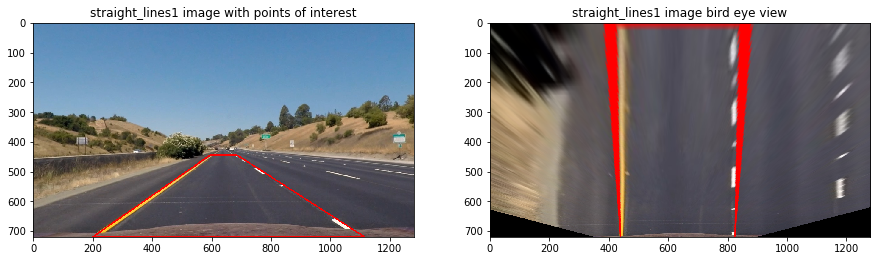

In [13]:
straight_lines1_src = mpimg.imread('./test_images/straight_lines1.jpg') #straight_lines1
straight_lines1_undistort = undistort_image(straight_lines1_src, camera_matrix, dist_coeffs)
draw_into_image(straight_lines1_undistort)

straight_lines1_transformed = transforming_image(straight_lines1_undistort)

plt.rc('figure', figsize=(15,15))

show_picture(straight_lines1_undistort, "straight_lines1 image with points of interest", (1,2), (0,0))
show_picture(straight_lines1_transformed, "straight_lines1 image bird eye view", (1,2), (0,1))


The picture in the bird's eye view shows the transformation of a curve. The marker strips in the bird's eye view are parallel but curved.

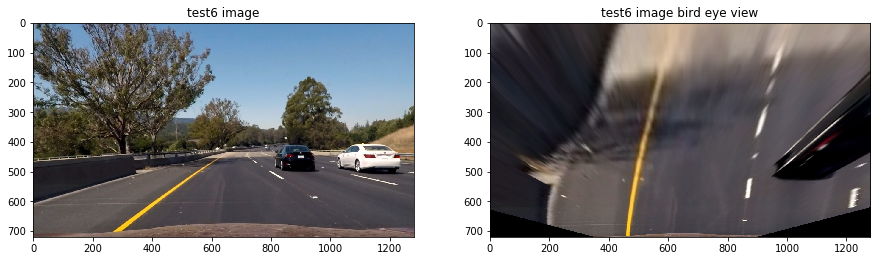

In [14]:
test2_src = mpimg.imread('./test_images/test6.jpg') 
test2_undistort = undistort_image(test2_src, camera_matrix, dist_coeffs)
test2_transformed = transforming_image(test2_undistort)

plt.rc('figure', figsize=(15,15))
show_picture(test2_undistort, "test6 image", (1,2), (0,0))
show_picture(test2_transformed, "test6 image bird eye view", (1,2), (0,1)) #

Calling all test images through the pipeline: distortion-corrected image, thresholded binary image and perspective transform 

In [15]:
def pipeline(img_src):
    undistort_img = undistort_image(img_src, camera_matrix, dist_coeffs)
    combined_binary_img = combined_binary(undistort_img)
    img_dest = transforming_image(combined_binary_img)
    return img_dest


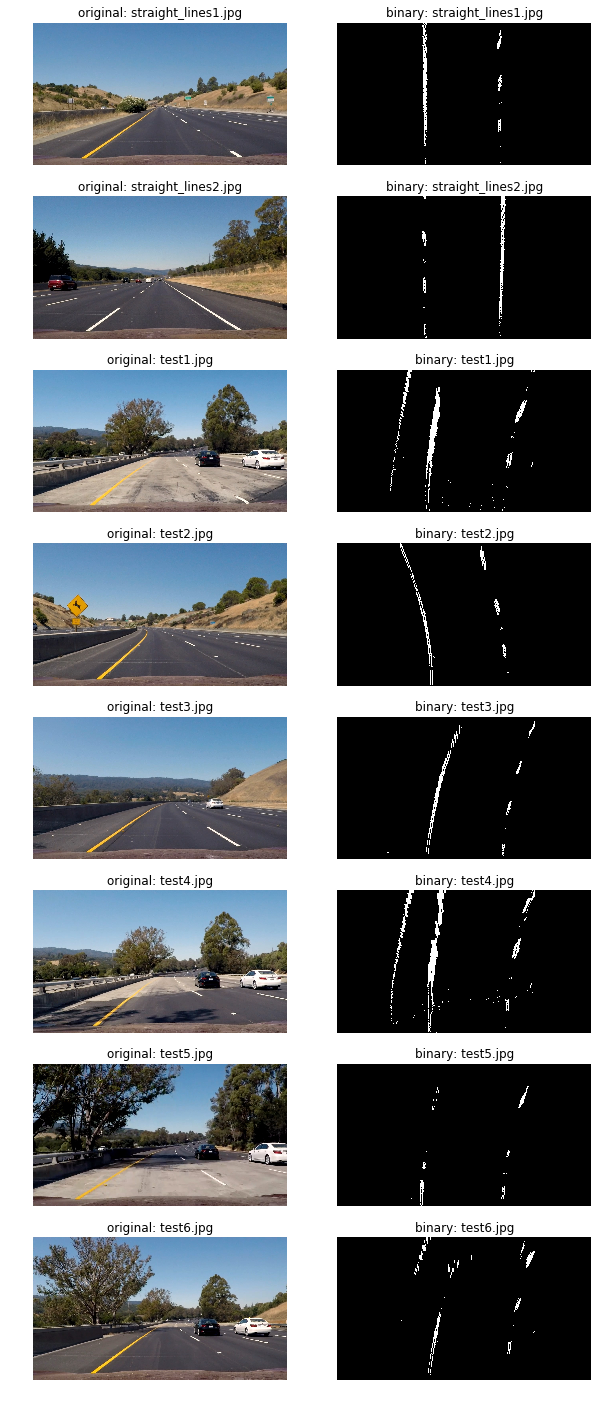

In [16]:
image_paths = glob.glob('./test_images/*.jpg')
                                          
plt.rc('figure', figsize=(10,25))

for i in range(0, 8):
    ax = plt.subplot2grid((8,2), (i,0))
    test_src = mpimg.imread(image_paths[i])
    ax.imshow(test_src) #, cmap=plt.get_cmap('gray'))
    ax.set_title("original: " + os.path.basename(image_paths[i]))
    ax.axis('off')

    ax = plt.subplot2grid((8,2), (i,1))
    transformed_image = pipeline(test_src)
    transformed_image = cv2.rectangle(transformed_image, (0, 0), (250, 720), (0, 0, 0), -1)
    transformed_image = cv2.rectangle(transformed_image, (1000, 0), (1280, 720), (0, 0, 0), -1)
    ax.imshow(transformed_image, cmap='gray')
    ax.set_title("binary: " + os.path.basename(image_paths[i]))
    ax.axis('off')

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

I use the sliding window algorithm to determine the polynomials of the two boundary lines. The image is divided into four parts. In the lower left half of the image, the x-position of the maximum Histogrammwertes of the left lane is determined. In the lower right half of the image, the x-position of the maximum Histogrammwertes of the right lane is determined.


Here the histogram for the sample images is shown (separation of the left and right maximum histograms is done later).

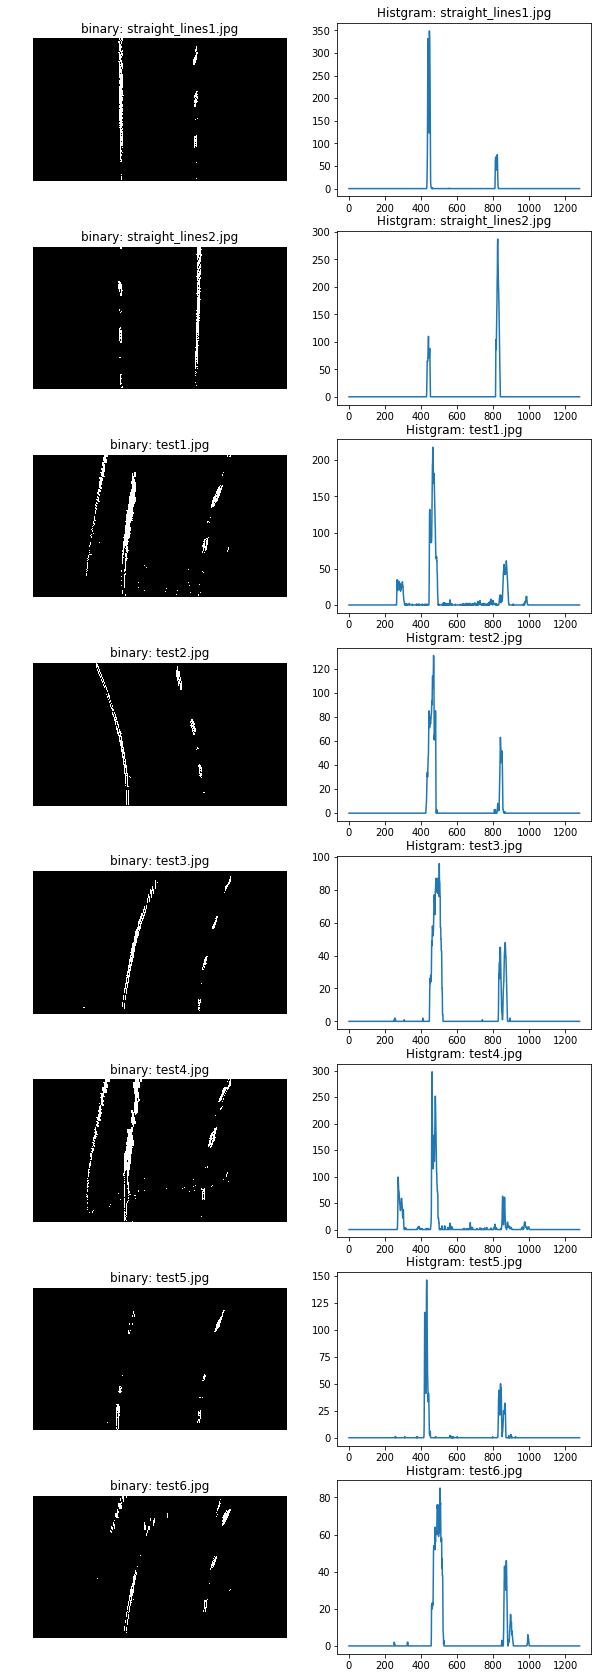

In [17]:
import numpy as np

image_paths = glob.glob('./test_images/*.jpg')
                                          
plt.rc('figure', figsize=(10,30))

for i in range(0, 8):
    ax = plt.subplot2grid((8,2), (i,0))
    test_src = mpimg.imread(image_paths[i])
    transformed_image = pipeline(test_src)
    transformed_image = cv2.rectangle(transformed_image, (0, 0), (250, 720), (0, 0, 0), -1)
    transformed_image = cv2.rectangle(transformed_image, (1000, 0), (1280, 720), (0, 0, 0), -1)
    ax.imshow(transformed_image, cmap='gray')
    ax.set_title("binary: " + os.path.basename(image_paths[i]))
    ax.axis('off')
    
    ax = plt.subplot2grid((8,2), (i,1))
    transformed_image = pipeline(test_src)
    transformed_image = cv2.rectangle(transformed_image, (0, 0), (250, 720), (0, 0, 0), -1)
    transformed_image = cv2.rectangle(transformed_image, (1000, 0), (1280, 720), (0, 0, 0), -1)

    histogram = np.sum(transformed_image[transformed_image.shape[0]//2:,:], axis=0)
    ax.plot(histogram)
    ax.set_title("Histgram: " + os.path.basename(image_paths[i]))
    

10 Search windows per lane are used. The coordinates are calculated for each search window. The pixels are determined per search window. If the number of pixels found is greater than 100 (min_good_pixels), then the search was successful and the coordinates are collected. From the coordinates found, the mean function determines the next middle Windows position (leftx_base and rightx_base). The left and right polynomials are justified from all the coordinates found. If no coordinates are found, the polynomial is taken from the last search.



(720, 0)

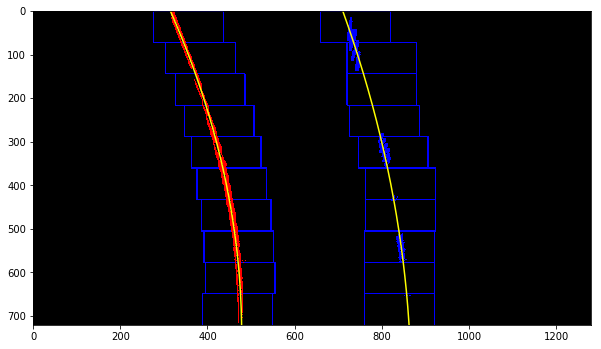

In [26]:
#Calculation of polynomials for street lanes
from queuelib import FifoDiskQueue


def compute_poly(img, queue_left, queue_right):

    
    transformed_image = pipeline(img) #pipeline2
    transformed_image = cv2.rectangle(transformed_image, (0, 0), (250, 720), (0, 0, 0), -1)
    transformed_image = cv2.rectangle(transformed_image, (1000, 0), (1280, 720), (0, 0, 0), -1)

    histogram = np.sum(transformed_image[transformed_image.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram

    midpoint_hist = histogram.shape[0]//2
    leftx_base = np.argmax(histogram[:midpoint_hist]) # starting point for the left line
    rightx_base = np.argmax(histogram[midpoint_hist:]) + midpoint_hist # starting point for the right line

    #print(midpoint_hist, leftx_base, rightx_base)
    out_img = np.dstack((transformed_image, transformed_image, transformed_image))*255


    non_zeros = transformed_image.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]

    num_windows = 10
    num_rows = transformed_image.shape[0]
    win_height = num_rows//num_windows
    win_half_width = 80 #50

    # Set minimum number of pixels found to recenter window
    min_good_pixels = 40 #100

    left_lane_coordinates = []
    right_lane_coordinates = []

    # Step through the windows one by one
    for window in range(num_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_max = num_rows - window*win_height
        win_y_min = num_rows - (window+1)* win_height
        
        #Width of the search window
        win_left_x_min = leftx_base - win_half_width
        win_left_x_max = leftx_base + win_half_width

        # Draw the left windows on the visualization image
        cv2.rectangle(out_img, (win_left_x_min, win_y_min), (win_left_x_max, win_y_max), [0,0,255],2)
        
        # Identify the nonzero pixels in x and y within the left window
        good_left_window_coordinates = ((non_zeros_x >= win_left_x_min) & (non_zeros_x <= win_left_x_max) \
                                        & (non_zeros_y >= win_y_min) & (non_zeros_y <= win_y_max)).nonzero()[0]
        left_lane_coordinates.append(good_left_window_coordinates)

        # If you found > min_good_pixels, recenter next window on their new leftx_base position
        if len(good_left_window_coordinates) > min_good_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))
        
        #Width of the search window
        win_right_x_min = rightx_base - win_half_width
        win_right_x_max = rightx_base + win_half_width
        
        # Draw the right windows on the visualization image
        cv2.rectangle(out_img, (win_right_x_min, win_y_min), (win_right_x_max, win_y_max), [0,0,255],2)
        
        # Identify the nonzero pixels in x and y within the right window
        good_right_window_coordinates = ((non_zeros_x >= win_right_x_min) & (non_zeros_x <= win_right_x_max) \
                                         & (non_zeros_y >= win_y_min) & (non_zeros_y <= win_y_max)).nonzero()[0]
        right_lane_coordinates.append(good_right_window_coordinates)
        
        # If you found > min_good_pixels, recenter next window on their new rightx_base position
        if len(good_right_window_coordinates) > min_good_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))
    
    # Concatenate the arrays of left lane indices
    left_lane_coordinates = np.concatenate(left_lane_coordinates)

    # Draw the left lane pixcels inside seach windows
    out_img[non_zeros_y[left_lane_coordinates], non_zeros_x[left_lane_coordinates]] = [255,0,0]

    win_left_x = non_zeros_x[left_lane_coordinates]
    win_left_y = non_zeros_y[left_lane_coordinates]

    #If no win_left points are found, then the polyfit is used by the last search
    if ((win_left_y.size != 0) and (win_left_x.size != 0)):
        polyfit_left = np.polyfit(win_left_y, win_left_x, 2)
        queue_left.append(polyfit_left)
        if (len(queue_left) >= 10):
            queue_left = queue_left[len(queue_left) - 10:]
    polyfit_left = np.average(queue_left, axis=0)

    win_y_points = np.linspace(0, num_rows-1, num_rows)

    #caculate the left polyfit
    left_polyfit_x = polyfit_left[0]*win_y_points**2 + polyfit_left[1]*win_y_points + polyfit_left[2]
    
    
    # Concatenate the arrays of indices
    right_lane_coordinates = np.concatenate(right_lane_coordinates)

    # Draw the right lane pixcels inside seach windows
    out_img[non_zeros_y[right_lane_coordinates], non_zeros_x[right_lane_coordinates]] = [0,0,255]
    
    win_right_x = non_zeros_x[right_lane_coordinates]
    win_right_y = non_zeros_y[right_lane_coordinates]

    
    #If no win_right points are found, then the polyfit is used by the last search
    if ((win_right_y.size != 0) and (win_right_x.size != 0)):
        polyfit_right = np.polyfit(win_right_y, win_right_x, 2)
        queue_right.append(polyfit_right)
        if (len(polyfit_right) >= 10):
            queue_right = queue_right[len(queue_right) - 10:]
    queue_right = np.average(queue_right, axis=0)
    
    #caculate the right polyfit
    right_polyfit_x = polyfit_right[0]*win_y_points**2 + polyfit_right[1]*win_y_points + polyfit_right[2]

    return left_polyfit_x, right_polyfit_x, out_img, transformed_image, win_y_points


queue_left = []
queue_right = []

img_src = mpimg.imread('./test_images/test2.jpg') #6
left_polyfit_x, right_polyfit_x, out_img, transformed_image, win_y_points = compute_poly(img_src, queue_left, queue_right)



plt.imshow(out_img)
plt.plot(left_polyfit_x, win_y_points, color='yellow')
plt.plot(right_polyfit_x, win_y_points, color='yellow')
plt.xlim(0, transformed_image.shape[1])
plt.ylim(transformed_image.shape[0],0)


#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [27]:
def compute_the_radius_of_curvature (polyfit_x, num_rows):
    #Define conversions in x and y from pixels space to meters. The calculation comes from Udacity 
    #More information can be found under U.S. government specifications for highway curvature: 
    #http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700  # meters per pixel in x dimension #
    
    # If no pixels were found return None
    win_y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(win_y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(win_y_points*ym_per_pix, polyfit_x*xm_per_pix, 2)
    curve_rad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curve_rad

def compute_average_curve_and_center_offset(left_polyfit_x, right_polyfit_x, num_rows):
    xm_per_pix = 3.7/700  # meters per pixel in x dimension

    #compute_average_curve
    left_curve_rad = compute_the_radius_of_curvature(left_polyfit_x, num_rows)
    right_curve_rad = compute_the_radius_of_curvature(right_polyfit_x, num_rows)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    
    # compute the center offset
    car_pos = 1280/2 #image.shape[1]/2 
    lane_center = (right_polyfit_x[num_rows-1] + left_polyfit_x[num_rows-1])/2 
    center_offset_pixels = abs(car_pos - lane_center)
    center_offset_in_mtrs = center_offset_pixels * xm_per_pix
    
    return "The average radius of curvature: {:.2f} m".format(average_curve_rad), \
            "Center offset: {:.2f} m".format(center_offset_in_mtrs)

num_rows = transformed_image.shape[0]
average_curve_rad, center_offset_in_mtrs = compute_average_curve_and_center_offset(left_polyfit_x, right_polyfit_x, num_rows)

print(average_curve_rad)
print(center_offset_in_mtrs)



The average radius of curvature: 676.55 m
Center offset: 0.16 m


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

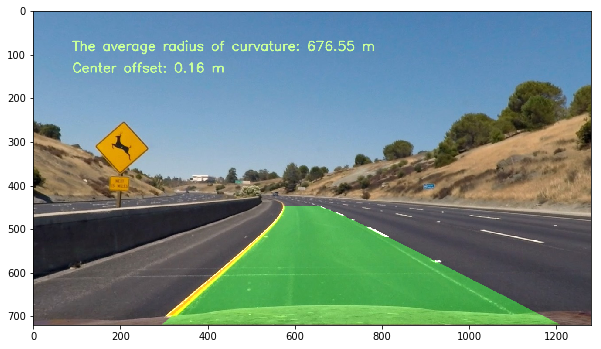

In [28]:
def compute_img_with_polygon(left_polyfit_x, right_polyfit_x, img_src, transformed_image, num_rows):
    out_img = np.dstack((transformed_image, transformed_image, transformed_image))*255

    win_y_points = np.linspace(0, num_rows-1, num_rows)

    left_line_points = np.array(np.transpose(np.vstack([left_polyfit_x, win_y_points])))

    right_line_points = np.array(np.flipud(np.transpose(np.vstack([right_polyfit_x, win_y_points]))))

    line_points = np.vstack((left_line_points, right_line_points))

    #compute the green polygon
    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
    
    unwarped = transforming_image(out_img, revers=True)
    
    undistort_img = undistort_image(img_src, camera_matrix, dist_coeffs)   
    
    final_img = cv2.addWeighted(undistort_img, 1, unwarped, 0.4, 0) #img_src
    
    average_curve_rad, center_offset_in_mtrs = compute_average_curve_and_center_offset(left_polyfit_x, right_polyfit_x, num_rows)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    cv2.putText(final_img, average_curve_rad, (90, 90), font, fontScale, (200,255,155), 2, cv2.LINE_AA)
    cv2.putText(final_img, center_offset_in_mtrs, (90, 140), font, fontScale, (200,255,155), 2, cv2.LINE_AA)
    
    return final_img

img_src = mpimg.imread('./test_images/test2.jpg')
num_rows = transformed_image.shape[0]
result_img = compute_img_with_polygon(left_polyfit_x, right_polyfit_x, img_src, transformed_image, num_rows)    
plt.imshow(result_img)


### Pipeline (video)
#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).



In [29]:
def final_pipeline(rgb_img):
    left_polyfit_x, right_polyfit_x, out_img, transformed_image, win_y_points = compute_poly(rgb_img, queue_left, queue_right)
    num_rows = transformed_image.shape[0]
    return compute_img_with_polygon(left_polyfit_x, right_polyfit_x, rgb_img, transformed_image, num_rows)

In [30]:
from moviepy.editor import VideoFileClip

queue_left = []
queue_right = []

video_clip = VideoFileClip("project_video.mp4")

new_clip  = video_clip.fl_image(final_pipeline) 
new_clip.write_videofile(filename="project_video_with_lines8.mp4", fps=new_clip.fps, \
                         verbose=False, progress_bar=False, audio=False)
print("finished")

finished


In [32]:
%%HTML
<video width="640" height="480" controls>
  <source src="./project_video_with_lines8.mp4" type="video/mp4">
</video>


### Discussion
#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?


It was very expensive to combine the different color spaces and filters until you got a useful result. For example, you can use the magnitude of the gradient filter to fix problems with bright surfaces. Unfortunately, the filter greatly magnifies the lines and disturbs the histogram for the line-search algorithm; That's why I don't use it here.

NEW: Shadows of trees make the pipeline still have some problems. I have inserted two queues for the left and right lane, each of which stores up to 10 Polyfit. About the stored Polyfit, I create the mean value. The mean value Polyfit is then used per image. Thus, there are no more distortions on the lines.

My pipeline doesn't work on the "Harder_challenge" track. The glass reflections and the right missing markers will mess up the calculation. Here, a polynomial mean value calculation could help.

Improved pipeline calculation:

You can divide the area between the lines in different areas. Depending on whether you find a lighter or dark surface, you would use a different filter combination for this area. So you would get less interference.

You could use neural nets and color the lines differently on the original images; e.g. from dark to light yellow, from dark to white, etc. Thus, the images would be more suitable for disturbances (tunnels, rain, etc.).
